# Tool, Agent 학습

## Agent
- LLM과 결합하여 복잡한 문제를 추론 능력과 도구를 이용하여 스스로 해결
- 계획-실행-반복의 순환 구조
- 에이전트는 주어진 목표를 달성하기 위해 필요한 단계를 스스로 계획하고 실행


**주요 동작 흐름**

1. 사용자 질문 (질문): 사용자가 "판교 용중헌 전화번호가 뭐야?"와 같은 질문을 합니다. 이 질문은 LLM이 자체적으로는 답할 수 없는 외부 정보에 대한 요청입니다.

2. 생각 (Thought): LLM은 질문을 분석하고, "어떤 도구를 사용해야 할까?"라고 스스로 생각합니다.

3. 행동 (Action): 이 단계는 LLM은 결정한 도구로 계획을 실제 행동으로 옮기는 과정입니다.

4. 관찰 (Observation): 도구가 실행되면, 실행 결과가 반환됩니다. 이는 LLM이 행동의 결과를 '관찰'하는 단계입니다. 이 관찰 결과를 통해 LLM은 원하는 정보를 얻었는지 확인합니다.

5. 정보 확인 및 반복: LLM은 '관찰'된 검색 결과가 질문에 대한 답인지 확인합니다.
    YES: 만약 검색 결과에 "판교 용중헌 전화번호: XXX-XXXX-XXXX"와 같이 원하는 정보가 있다면, LLM은 최종 답변을 생성하고 동작을 종료합니다.

    NO: 만약 검색 결과가 불완전하거나 원하는 정보를 찾지 못했다면, 다시 생각 (Thought) 단계로 돌아가 다른 검색어를 사용하거나 다른 도구를 시도하는 등 새로운 계획을 세웁니다.


### 0. 환경설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH15-Agents")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agents


## 도구(Tool)
LLM이 외부와 상호작용하기 위한 인터페이스

### PythonREPLTool

In [3]:
from langchain_experimental.tools import PythonREPLTool

# Agent에 바로 붙여서 사용
# 파이썬 코드를 실행하는 도구를 생성합니다.
python_tool = PythonREPLTool()

In [4]:
# 파이썬 코드를 실행하고 결과를 반환합니다.
print(python_tool.invoke("print(100 + 200)"))

Python REPL can execute arbitrary code. Use with caution.


300



In [8]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda

def print_and_execute(code, debug=False):
    if debug:
        print("CODE: ")
        print(code)
    return python_tool.invoke(code)

# 파이썬코드 작성을 요청
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are Raymond Hetting, an expert python programmer, well versed in meta-programming and elegant, concise and short but well documented code. You follow the PEP8 style guide. "
            "Return only the code, no intro, no explanation, no chatty, no markdown, no code block, no nothing. Just the code.",
        ),
        ("human", "{input}"),
    ]
)


# LLM 모델 생성
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# StrOutputParser까지 실행하면 코드를 받아온다(content를 확인하면 알수 있음)
# RunnableLambda 코드를 바다아서 실행한다
chain = prompt | llm | StrOutputParser() | RunnableLambda(print_and_execute)

In [ ]:
# 결과 출력(StrOutputParser까지 실행)
print(chain.invoke("로또 번호 생성기를 출력하는 코드를 작성하세요."))

import random

def generate_lotto_numbers():
    return sorted(random.sample(range(1, 46), 6))

print(generate_lotto_numbers())


In [ ]:
# 결과 출력(RunnableLambda까지 실행)
print(chain.invoke("로또 번호 생성기를 출력하는 코드를 작성하세요."))

[8, 18, 22, 28, 29, 37]



### Tavily 검색 API를 활용하여 검색

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

# 도구 생성
tool = TavilySearchResults(
    # 반환할 최대 검색 결과수 
    max_results=6,
    # 짧은 답변 포함여부
    include_answer=True,
    # html 컨텐츠 포함여부
    include_raw_content=True,
    # include_images=True,

    # 검색 깊이
    # advanced를 사용하면 더 자세히 조사하는 대신 비용이 더 든다
    # search_depth="advanced", # or "basic"

    # 검색을 할 도메인을 지정
    include_domains=["github.io", "wikidocs.net"],

    # 검색에서 제외할 도메인 목록 지정
    # exclude_domains = []
)

C:\Users\yujap\AppData\Local\Temp\ipykernel_10756\1850249003.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(


In [ ]:
# 도구 실행
tool.invoke({"query": "Gemini에 대해 알려주세요"})

### 사용자 정의 도구

In [13]:
from langchain.tools import tool

@tool
def add_numbers(a: int, b: int) -> int:
    """Add tow numbers"""
    return a+b


@tool
def multiply_numbers(a: int, b: int) -> int:
    """Add tow numbers"""
    return a*b

In [ ]:
# tool 실행
add_numbers.invoke({"a":3, "b":4})

7

In [ ]:
# tool 실행
multiply_numbers.invoke({"a":3, "b":5})

15

### 뉴스기사 검색도구

In [17]:
from langchain_teddynote.tools import GoogleNews

# 도구 생성
news_tool = GoogleNews()
# 최신 뉴스 검색
news_tool.search_latest(k=2)

[{'url': 'https://news.google.com/rss/articles/CBMib0FVX3lxTE5OZHNfZEdDR2lSMDF2dGZHVEZrSTBoMjJiQk1DX3dEQXc2SkdVSmwwTk5oUGJXSXNVUXBidTlYbWpybldmbFhZakZQbEJqQW55RmhTbHZ5WU9xSTdRaE4wdUozLTZkRDVNcjRmVk43SQ?oc=5',
  'content': '구금 한국인 출국 절차 시작...재입국 불이익 우려 해소될까 - 한겨레'},
 {'url': 'https://news.google.com/rss/articles/CBMiWkFVX3lxTFBrZkQ0NklGXzlqNVo1NkpPOXMyX3FSdUZWWENGdGRPYnFSRnZEYWVkMFJXckVmYXpRVFgzX3pDM2ZSdXAxYlhGR3M3dkRvMk1UUXpzQjdPbFAzZ9IBX0FVX3lxTE1UUnpJWE1fVTdEUVRvMVJMODNYblB1RDgzSHduWEJKN01mb0JfUHg0QmtpUVlqLS1ianprUTZZaDBtNmdxVEdCWkZQUWc2OVc4WGJxeTZ2OENaWDNXQmtR?oc=5',
  'content': '특검 “권성동, 비서관 통해 공범에 몰래 접촉 시도···증거인멸 우려” - 경향신문'}]

In [18]:
# 키워드로 뉴스 검색
news_tool.search_by_keyword("openai", k=3)

[{'url': 'https://news.google.com/rss/articles/CBMi0AFBVV95cUxOeUZIMnpXVXFWQ1ZWVVF1OEZvNHBDYWNMeEJGM2padXQ0dUtuV2hLblhBZDl4QUNzd0FrN0lRVDBGVU5GaGRjRmxKQzJuMWNQUkRfaW0yd1R0ak1HUm51TDVkd3FBNmc3dlUxdUpsaUVkVUpqS0JWUGc3Sk90WHhoaHh0ZVdkZ2FCWFlKYmxaaFd2UEplamRqVDdINlNuU3JhZS1CbzJHZDVIdWNES0p6MFZWV1ZNbFY0bEdWaHpIeWE1aVBmbnFBYUE3c1V6TUd4?oc=5',
  'content': '기술 9/9: 중국 AI 기업 5,000개 돌파, OpenAI 1,150억 달러 투자, Deep Fission 지하 원자로 가동 - Vietnam.vn'},
 {'url': 'https://news.google.com/rss/articles/CBMigwFBVV95cUxQMmQ3ejBfYmZoODdaaGVaZDdld295VVd1LTRheUY3SVAtZWMyQnBxSHVORFdnZ3A0REktNDZIUHh1cHBsN192dVBXRGhhWi1sb3ZiZk9XS2V1ZXhQZVdIemdvaVNtQ210N2ZuZGgzSXQ1dE1BQVBGX3lPZkwxRTVwOC1mZw?oc=5',
  'content': 'OpenAI, 2029년까지 AI 도입에 1,150억 달러 규모 투자 예상 - Cryptopolitan'},
 {'url': 'https://news.google.com/rss/articles/CBMidkFVX3lxTE5ZUUktTTJJNDZmMGhzdFVQWkhidHNsUThmbTJRRi1yd3BXY2R4M19SU3NlT3pieFlHVHcxUUl2YUFmRlJCaGV4U2pVbktKSU1sN0t6OEZqMHE1ZXhqNXB6UVRSQk5GVmtFajJReXp2NEJ6MVdWX3c?oc=5',
  'content': 'Foundry Models에

In [19]:
from langchain_teddynote.tools import GoogleNews
from langchain.tools import tool
from typing import List, Dict


# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    print(query)
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

In [20]:
# 실행 결과
search_keyword.invoke({"query": "Google gemini"})

Google gemini


[{'url': 'https://news.google.com/rss/articles/CBMi5wJBVV95cUxPWXFtN01vZzJERDZSSWhsUVJVejZvYkl2QU1TYV9ZSHE4bUphMHFLR1NucGU3eE5KR0QwazBfNEhLWE9nUW5qUGtuUGhoMkxZaW9lRkF3OGJCR2tTYkN1NktpR0MxeU1qdy1zV1JVRnRiUF9sdjFWQmtTWnh1THI1Wlo2Si1tT0ZNZnNHRGNCbkJEOHFzR3RkUlpWSElQNkR0dktscl9xNktyVUlaSlUtRE9GVHFuQzVDQlhidHREMTZEOWJzcDBUMGVUVUJObF9OcGt6b2JKY3l6QUxUM0w5bktKZXR1TUViNDQ1Sm9PWV81VWlPeWVUWmVXSVA2Q0c4SnZoLS1TQ0ZfRFU3SUs0ZkdxQzZkYkpXeWtUYlRmVHJKdDl4R0NSZ3ZZelQ2RlJKZC12Q0tOd2lzVlU5REhsUnhJNzdYLUIzN284R3dmU0ZTT3VGdEJGb0tsaFEwUENUUDg1d3Rybw?oc=5',
  'content': 'Google Search AI 모드는 이제 Gemini 2.5의 사용자 정의 버전을 사용하여 상세하고 개인적인 답변을 제공하는 전 세계적으로 힌디어로 제공됩니다. - pohangtong.com'},
 {'url': 'https://news.google.com/rss/articles/CBMiSEFVX3lxTFA5U2Ewa3pPU3lZMW96U3VHbFZHU3FQb01QUktUODFTVXd2elJkYll6MjZvTFV1a2RmNHdsRXZoM0piRWtBSWIwWA?oc=5',
  'content': 'AI 환경 영향 분석: 구글 Gemini 실제 검증 - 브런치스토리'},
 {'url': 'https://news.google.com/rss/articles/CBMifEFVX3lxTFBJZVU3cDN5eVhKMUM1eXRDeDFPeGF3NURtTzdGQzU3SjExQ2hBMm9jQ3VKUGZ

## Agent
### 1.도구생성

In [21]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL
from llama_parse import LlamaParse

# 도구 생성
# GoogleNews 2건을 검색
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=2)


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result
    


@tool
def read_pdf_with_llamaparse(file_path: str) -> str:
    """Read a PDF file and return its structured content using LlamaParse.
    The function takes the file path as input and returns text formatted as markdown.
    """
    try:
        # LlamaParse 객체 초기화
        parser = LlamaParse(
            result_type="markdown"  # 결과를 마크다운 형식으로 반환하도록 설정
        )

        # PDF 파일 파싱
        # parse 메서드는 내부적으로 API를 호출하여 파일을 처리
        documents = parser.load_data(file_path)

        # 파싱된 문서의 내용을 하나의 문자열로 결합
        if not documents:
            return "No content found in the PDF file."

        full_content = ""
        for doc in documents:
            full_content += doc.text
        
        return full_content
    
    except Exception as e:
        return f"Error using LlamaParse: {e}"
    

print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")

print(f"도구 이름: {read_pdf_with_llamaparse.name}")
print(f"도구 설명: {read_pdf_with_llamaparse.description}")


도구 이름: search_news
도구 설명: Search Google News by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.
도구 이름: read_pdf_with_llamaparse
도구 설명: Read a PDF file and return its structured content using LlamaParse.
    The function takes the file path as input and returns text formatted as markdown.


In [23]:
# tools 정의
tools = [search_news, python_repl_tool,read_pdf_with_llamaparse]

### 2. Agent 프롬프트 생성

In [26]:
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 생성
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공합니다. (도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `read_pdf_with_llamaparse` tool for load pdf file.",
        ),
        ("placeholder", "{chat_history}"), # 멀티턴일때 사용
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"), # agent가 동작하면서 중간중간 메모를 남김
    ]
)

### 3. Agent 생성

In [29]:
## 3. Agent 생성
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Agent 생성
agent = create_tool_calling_agent(llm, tools, prompt)

### 4. AgentExecutor

In [31]:
from langchain.agents import AgentExecutor
import nest_asyncio

nest_asyncio.apply()
# AgentExecutor 생성
# Agnent를 AgentExecutor를 이용해야만 실행하고 컨트롤이 가능함
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True, # Agent가 실행 될때마다 실행 기록을 남겨둠. 메시지를 보려면 True
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
)

# AgentExecutor 실행
result = agent_executor.invoke({"input": "data/deoksugung.pdf"})

print("Agent 실행 결과:")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `read_pdf_with_llamaparse` with `{'file_path': 'data/deoksugung.pdf'}`


Started parsing the file under job_id d64c7d8f-7957-495e-9c76-dbe37f4c9643
관람정보
# 관람정보

100-120 서울시 중구 세종대로 99 / deoksugung.go.kr / 02-771-9952

# 관람시간

09:00~21:00

●마감 1시간 전까지 입장해야 하며 매주 월요일은 쉽니다

# 입장요금

어른(19~64세) 1,000원(10인 이상 800원)

# 무료 안내 시간

| 국어                         | 화                                 | 수                                        | 목요일                                             | 금요일 | 토요일     | 일요일     |     |
| -------------------------- | --------------------------------- | ---------------------------------------- | ----------------------------------------------- | --- | ------- | ------- | --- |
| 11:00, 14:00, 15:00, 16:30 | 10:00, 11:00, 14:00, 15:00, 16:30 | 10:00, 11:00, 13:00, 14:00, 15:00, 16:30 | 11:00, 13:00, 13:30, 14:00, 14:30, 15:00, 16:30 |     |         |         |     |
| 영어                         | 공휴일               

### Stream출력으로 단계별 결과 확인

In [32]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
    handle_parsing_errors=True,
)

In [33]:
# 스트리밍 모드로 실행합니다
result = agent_executor.stream({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계 출력
    print(step)
    print("===" * 20)

{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': 'AI 투자'}, log="\nInvoking: `search_news` with `{'query': 'AI 투자'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_zCnXS76t9Rh0qY3HaHZ8YHjF', 'function': {'arguments': '{"query":"AI 투자"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'service_tier': 'default'}, id='run--aad0672d-e749-4938-b566-e8c53e5145c3', tool_calls=[{'name': 'search_news', 'args': {'query': 'AI 투자'}, 'id': 'call_zCnXS76t9Rh0qY3HaHZ8YHjF', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"AI 투자"}', 'id': 'call_zCnXS76t9Rh0qY3HaHZ8YHjF', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_zCnXS76t9Rh0qY3HaHZ8YHjF')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_zCnX

### 중간 단계 출력을 사용자 정의 함수로 출력
실행시에 중간 단계를 출력해 사용자에게 제공(디버깅용)

In [34]:
from langchain_teddynote.messages import AgentStreamParser

agent_stream_parser = AgentStreamParser()

In [ ]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    # print(step)
    agent_stream_parser.process_agent_steps(step)

[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
categories = ['A', 'B', 'C', 'D']
values = [10, 15, 7, 12]

# 막대그래프 그리기
plt.bar(categories, values, color='blue')

# 그래프 제목과 레이블 설정
plt.title('Sample Bar Graph')
plt.xlabel('Categories')
plt.ylabel('Values')

# 그래프 보여주기
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\nimport numpy as np\n\n# 데이터 준비\ncategories = ['A', 'B', 'C', 'D']\nvalues = [10, 15, 7, 12]\n\n# 막대그래프 그리기\nplt.bar(categories, values, color='blue')\n\n# 그래프 제목과 레이블 설정\nplt.title('Sample Bar Graph')\nplt.xlabel('Categories')\nplt.ylabel('Values')\n\n# 그래프 보여주기\nplt.show()"}`





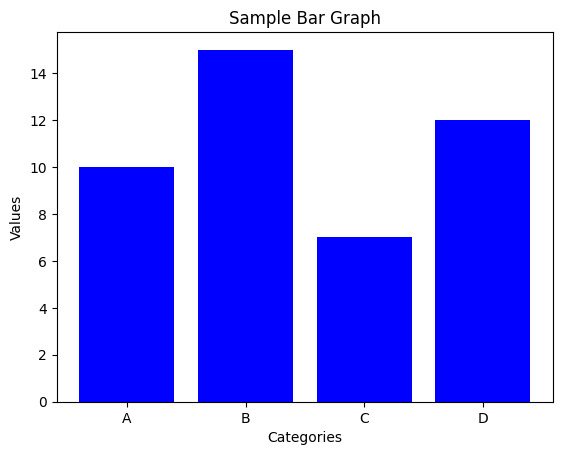

[관찰 내용]
Observation: 
[최종 답변]
막대그래프를 성공적으로 그렸습니다. 그래프는 카테고리 A, B, C, D에 대한 값들을 보여주고 있습니다. 각 카테고리는 서로 다른 높이의 막대로 표현되어 있습니다. 추가적인 질문이나 다른 그래프를 원하시면 말씀해 주세요!


In [35]:
# 스트리밍 방식으로 결과를 출력
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여  막대그래프를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    # print(step)
    agent_stream_parser.process_agent_steps(step)

In [36]:
# AgentCallbacks와 AgentStreamParser를 langchain_teddynote.messages에서 가져옵니다.
from langchain_teddynote.messages import AgentCallbacks, AgentStreamParser


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print("<<<<<<< 도구 호출 >>>>>>")
    print(f"Tool: {tool.get('tool')}")  # 사용된 도구의 이름을 출력합니다.
    print("<<<<<<< 도구 호출 >>>>>>")


# 관찰 결과를 출력하는 콜백 함수입니다.
# 관찰 결과를 통해 LLM은 원하는 정보를 얻었는지 확인
def observation_callback(observation) -> None:
    print("<<<<<<< 관찰 내용 >>>>>>")
    print(
        f"Observation: {observation.get('observation')[0]}"
    )  # 관찰 내용을 출력합니다.
    print("<<<<<<< 관찰 내용 >>>>>>")


# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print("<<<<<<< 최종 답변 >>>>>>")
    print(result)  # 최종 답변을 출력합니다.
    print("<<<<<<< 최종 답변 >>>>>>")


# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수를 설정합니다.
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱합니다.
agent_stream_parser = AgentStreamParser(agent_callbacks)

In [38]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream({"input": "AI 투자관련 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>
<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMiYEFVX3lxTE5vUFFSQS1uWEowWVZKUWJmSGd3Rm1mendLeWU0blJtdFVMRDVER1JnTHBKc2MzZ1F5eUtaLVROSldDRXVwa0g5UFpzcE9tZkhlQlhGT3ZOVEc2UGJCdWgxXw?oc=5', 'content': '"8월 국내 벤처투자 1조원 돌파"…AI 쏠림 강화 - 아시아경제'}
<<<<<<< 관찰 내용 >>>>>>
<<<<<<< 최종 답변 >>>>>>
다음은 AI 투자와 관련된 최근 뉴스입니다:

1. **[8월 국내 벤처투자 1조원 돌파…AI 쏠림 강화 - 아시아경제](https://news.google.com/rss/articles/CBMiYEFVX3lxTE5vUFFSQS1uWEowWVZKUWJmSGd3Rm1mendLeWU0blJtdFVMRDVER1JnTHBKc2MzZ1F5eUtaLVROSldDRXVwa0g5UFpzcE9tZkhlQlhGT3ZOVEc2UGJCdWgxXw?oc=5)**  
   이 기사는 8월에 국내 벤처투자가 1조원을 돌파했으며, AI 분야에 대한 투자 집중이 강화되고 있다는 내용을 다루고 있습니다.

2. **[VC업계, 피지컬 AI·로봇 선점 경쟁...정책 리스크에 뜨는 '자동화' - 인베스트조선](https://news.google.com/rss/articles/CBMigwFBVV95cUxQVXQzb1lMdlA0M1haT2dCR1FRLS1OWWw1QlFpZ00wOUdaTzBKblZkMWtJM2sxalhOS1ZWR2o5SU9VaTN0R0l3bmpYZE4ycklacWktVm5TVGlDZ0d3TXZFS1RRMFZvOWh3djJoSTVQNFpWNF9PZEROcUl5c2pQNVd5OGFYNA?oc=5)**  
   이 기사에서는 VC